In [2]:
import os
import sys
import copy
import pickle
import concurrent.futures
import numpy as np
import pandas as pd

import cantera as ct
import rmgpy.chemkin

sys.path.append('/work/westgroup/harris.se/autoscience/autoscience_workflow/workflow/scripts/kinetics')
import kineticfun


import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load the base model
basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/rmg_model'
# basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/naive_rmg_model'

base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)


438749050.py:8 <module> INFO Thermo file has default temperature range 300.0 to 1000.0 and 1000.0 to 5000.0


In [4]:
base_delay = 0.14857535  # /work/westgroup/harris.se/autoscience/autoscience/butane/rmg_model -- original 24 hour model
base_speed = 0.41552749  # condition 4

In [17]:
# read all of the results
N = 5000
delays = np.ones(N) * base_delay
results_dir = '/scratch/harris.se/autoscience/correlated/results/ignition_delay'
# results_dir = '/scratch/harris.se/autoscience/correlated/results/flame_speeds'
total = 0.0
count = 0
# for i in range(0, N):
#     result_file = os.path.join(results_dir, f'delay_{i:04}.txt')
#     if not os.path.exists(result_file):
#         continue
#     with open(result_file, 'r') as f:
#         result = float(f.readline())
#         delays[i] = result
#         count += 1
#         total += result
# ignition_delay_df = pd.DataFrame(delays, columns=['delays'])
# ignition_delay_df.to_csv('ignition_delays_correlated.csv')

ignition_delay_df = pd.read_csv('ignition_delays_correlated.csv')
delays = ignition_delay_df['delays'].values

In [16]:
# read all of the results
N = 5000
flame_speeds = np.ones(N) * base_speed
results_dir = '/scratch/harris.se/autoscience/correlated/results/flame_speeds'
total = 0.0
count = 0
# for i in range(0, N):
#     result_file = os.path.join(results_dir, f'flame_speed_{i:04}.txt')
#     if not os.path.exists(result_file):
#         continue
#     with open(result_file, 'r') as f:
#         result = float(f.readline())
#         flame_speeds[i] = result
#         count += 1
#         total += result

# flame_speeds_df = pd.DataFrame(flame_speeds, columns=['flame_speeds'])
# flame_speeds_df.to_csv('flame_speeds_correlated.csv')

flame_speeds_df = pd.read_csv('flame_speeds_correlated.csv')
flame_speeds = flame_speeds_df['flame_speeds'].values

In [13]:
flame_speeds_df

,Unnamed: 0,flame_speeds
0,0,0.438111
1,1,0.477879
2,2,0.236785
3,3,0.244558
4,4,0.387810
...,...,...
4995,4995,0.417085
4996,4996,0.480700
4997,4997,0.433484
4998,4998,0.504333


In [18]:
# We want to find out which reactions give the most change per perturbation
# so divide the change in flame speed by the percent perturbation

# First compute the numerator: how much the flame speed changed
delta_speed = flame_speeds - base_speed
percent_change = delta_speed / base_speed * 100.0
change_matrix = np.tile(percent_change, (len(reaction_list), 1)).transpose()


In [19]:
flame_speeds

array([0.43811092, 0.47787935, 0.23678506, ..., 0.43348418, 0.50433334,
       0.22827245])

In [20]:
change_matrix.shape

(5000, 1822)

In [21]:
# Next, we need to know how much reaction was perturbed, so we have to regenerate or reload the matrix of perturbations
randoms_file = '/work/westgroup/harris.se/autoscience/autoscience/uncertainty/workflow/correlated_uncertainty/randoms1001.npy'
perturbation = np.load(randoms_file)
perturbation[perturbation == 0] = 'nan'
# turn zeros to nan to avoid divide by zero error

sensitivity = np.divide(change_matrix, perturbation)

avg_sensitivity = np.nanmean(sensitivity, axis=0)

abs_avg_sens = np.abs(avg_sensitivity)

In [22]:
# sort by absolute value of average sensitivity
order = np.arange(0, len(reaction_list))
most_sensitive = [x for _, x in sorted(zip(abs_avg_sens, order))][::-1]

In [30]:
# print the top parameters
for i in range(0, 1500):
    index = most_sensitive[i]
    if index > len(reaction_list):
        index = index - len(reaction_list)
        print(index, '\t', species_list[index])
    else:
        try:
            if reaction_list[index].family != 'H_Abstraction' and \
                reaction_list[index].family != 'Disproportionation' and \
                reaction_list[index].family != 'intra_H_migration' and \
                reaction_list[index].family != 'R_Addition_MultipleBond':
                continue
            print(index, '\t', reaction_list[index], '\t', reaction_list[index].family)
        except AttributeError:
            continue
            print(index, '\t', reaction_list[index], '\t', 'PDEP')

1356 	 [CH2]C(=O)COO(911) + C3KET21(73) <=> CH3COCH2O2(72) + C3KET21(73) 	 H_Abstraction
764 	 C2H3(22) + C4H8-1(188) <=> C2H4(11) + C4H71-3(190) 	 H_Abstraction
389 	 CH2(23) + NC3H7(92) <=> CH3(18) + C3H6(12) 	 Disproportionation
854 	 PC4H9(182) + C4H71-1,3OOH(238) <=> C4H8-1(188) + CC(CCOO)OO(787) 	 Disproportionation
1345 	 [CH2]C(=O)COO(911) + NC3H7(92) <=> C3H6(12) + C3KET21(73) 	 Disproportionation
1314 	 C3KET21(73) + C4H8OOH2-4O2(229) <=> CH3COCH2O2(72) + CC(CCOO)OO(787) 	 H_Abstraction
1524 	 CH3O(31) + IC3H7(93) <=> CH3OH(30) + C3H6(12) 	 Disproportionation
1046 	 CH2CHO(21) + C4H71-4(191) <=> CH3CHO(35) + C4H6(194) 	 Disproportionation
1319 	 [CH2]C(=O)COO(911) + CC(CCOO)OO(787) <=> C3KET21(73) + C4H72-2,4OOH(244) 	 H_Abstraction
767 	 H(14) + [CH2]C[CH]C(748) <=> H2(13) + C4H71-3(190) 	 Disproportionation
799 	 C4H71-3(190) + PC4H9(182) <=> C4H6(194) + butane(1) 	 Disproportionation
1036 	 HO2(16) + C4H71-4(191) <=> H2O2(17) + C4H6(194) 	 Disproportionation
1794 	 C3H5O(1

297 	 C2H3(22) + PC4H9(182) <=> C2H2(25) + butane(1) 	 Disproportionation
328 	 C4H71-1,3OOH(238) <=> C4H72-2,4OOH(244) 	 intra_H_migration
1661 	 C2H5O2H(48) + C4H8OOH2-4O2(229) <=> C2H5O2(47) + CC(CCOO)OO(787) 	 H_Abstraction
737 	 CH2CHO(21) + C4H8-2(189) <=> CH3CHO(35) + C4H71-3(190) 	 H_Abstraction
1769 	 NC3H7(92) + C4H8OOH2-4(223) <=> C3H6(12) + SC4H9O2H(187) 	 Disproportionation
849 	 SC4H9(183) + C4H72-2,4OOH(244) <=> C4H8-2(189) + CC(CCOO)OO(787) 	 Disproportionation
1593 	 OCHO(38) + CC(CC[O])OO(777) <=> HOCHO(40) + NC4KET13(252) 	 Disproportionation
979 	 C2H5O(49) + C4H8OOH1-3O2(225) <=> CH3CHO(35) + CC(CCOO)OO(787) 	 Disproportionation
1766 	 C2H5(33) + SC4H9O2(186) <=> C2H4(11) + SC4H9O2H(187) 	 Disproportionation
1222 	 C3H5-A(94) + C3H5O(129) <=> C2H3CHO(74) + C3H6(12) 	 Disproportionation
1621 	 CH2(23) + C2H4(11) <=> CH3(18) + C2H3(22) 	 H_Abstraction
550 	 CH3CO(20) + C2H5(33) <=> CH2CO(24) + C2H6(32) 	 Disproportionation
1796 	 C3H5O(129) + [CH2]C=C[CH2](2534) <=> 

In [86]:
np.nanmin(abs_avg_sens)

0.019865431294464803

In [81]:
perturbation.shape

(5000, 1822)

In [33]:
np.min(percent_change)

-53.15516909459394

(array([  4.,   2.,  13.,  17.,  21.,  28.,  32.,  28.,  47.,  47.,  35.,
         52.,  39.,  51.,  49.,  43.,  53.,  60.,  45.,  69.,  55.,  58.,
         49.,  88.,  69.,  77.,  70.,  87.,  76.,  94., 101.,  84., 105.,
         88.,  87.,  96.,  83.,  84.,  93., 107.,  91.,  90.,  84.,  93.,
        103.,  58.,  81.,  88.,  76.,  91.,  89.,  83.,  78.,  74.,  83.,
         69.,  69.,  62.,  65.,  79.,  76.,  66.,  57.,  61.,  70.,  63.,
         52.,  40.,  56.,  37.,  41.,  32.,  36.,  28.,  38.,  32.,  36.,
         30.,  19.,  17.,  17.,  13.,  14.,  15.,  11.,   8.,   7.,   7.,
          4.,   2.,   4.,   6.,   2.,   2.,   3.,   3.,   0.,   0.,   2.,
          1.]),
 array([0.19465315, 0.19977365, 0.20489415, 0.21001466, 0.21513516,
        0.22025566, 0.22537616, 0.23049666, 0.23561717, 0.24073767,
        0.24585817, 0.25097867, 0.25609917, 0.26121968, 0.26634018,
        0.27146068, 0.27658118, 0.28170168, 0.28682219, 0.29194269,
        0.29706319, 0.30218369, 0.30730419, 0.

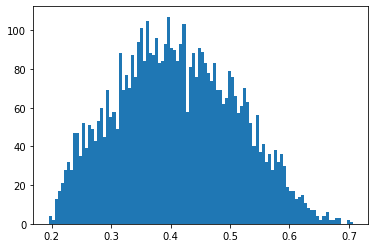

In [29]:
plt.hist(flame_speeds, bins=100)